In [29]:
import pandas as pd
import dask.dataframe as dd
import tarfile
from dask.delayed import delayed
import scipy
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import surprise

from surprise import Dataset, Reader
from surprise import SVD, SVDpp, NMF
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise import accuracy

from sklearn.manifold import TSNE

from sklearn.neighbors import DistanceMetric

from sklearn.decomposition import PCA

from sklearn.neighbors import NearestNeighbors

## Reading Data

In [15]:
famous_tracks = pd.read_csv('data/features.csv')
df_1kfamous   = pd.read_csv('data/df_1kfamous.csv')

## SVD Using Surprise library


Setup dataframe to only take the famous tracks computed before

Let's check how many unique users and tracks we have !

In [16]:
len(df_1kfamous['user-id'].unique()), len(df_1kfamous['track-id'].unique())

(805, 7938)

Compute scoring for each track id based on mean and standard deviation of users plays

In [17]:
# compute mean and std for normalization
user_means = df_1kfamous.groupby('user-id').mean()['plays']
user_std   = df_1kfamous.groupby('user-id').std(ddof=0)['plays'].replace(0, 1)

# normalize plays
df_1kfamous['norm_plays'] = df_1kfamous.apply(lambda x : (x['plays'] - user_means.loc[x['user-id']])/(user_std.loc[x['user-id']]), axis=1)

# linear binning on the number of plays
df_1kfamous['cat_plays'] = pd.cut(df_1kfamous['norm_plays'], bins=10, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# quartile binning
df_1kfamous['qcat_plays'] = pd.qcut(df_1kfamous['norm_plays'], 10, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

<AxesSubplot:ylabel='Frequency'>

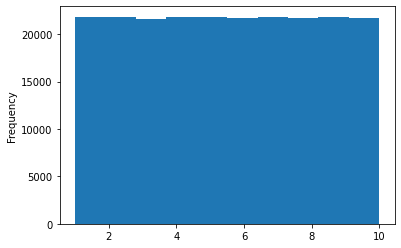

In [18]:
df_1kfamous['qcat_plays'].astype(int).plot(kind='hist')

In [19]:
df_1kfamous['qcat_plays'] = df_1kfamous['qcat_plays'].astype(int)
mean_per_track = df_1kfamous.groupby('track-id').mean()['qcat_plays']

In [20]:
df_1kfamous['test_plays'] = df_1kfamous.apply(lambda x : x['qcat_plays'] - mean_per_track.loc[x['track-id']], axis=1)

<AxesSubplot:ylabel='Frequency'>

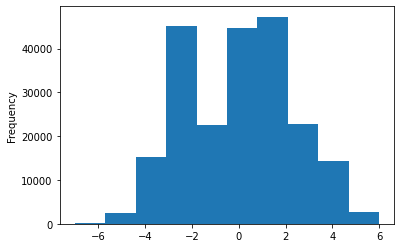

In [21]:
df_1kfamous['test_plays'].astype(int).plot(kind='hist')

In [22]:
# linear binning on the number of plays
df_1kfamous['new_plays'] = pd.cut(df_1kfamous['test_plays'], bins=10, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

<AxesSubplot:ylabel='Frequency'>

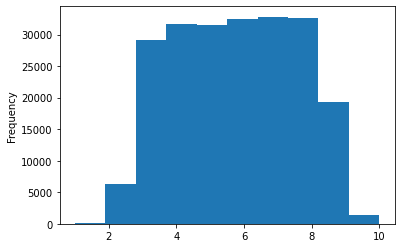

In [23]:
df_1kfamous['new_plays'].astype(int).plot(kind='hist')

In [24]:
df_1kfamous['new_plays'] = df_1kfamous['new_plays'].astype(int)

## Removing Users with low number of listens

In [27]:
df_1kfamous['user_count'] = df_1kfamous.groupby('user-id').transform(lambda x : x.count())['plays']

df_reduced = df_1kfamous[df_1kfamous['user_count'] > 10]

## Setup surprise datastructures

In [30]:
#Initialize Reader class
# Our rating scale is from 1 to 10
reader = Reader(rating_scale=(1, 10))

# now we apply the binning
ndata = Dataset.load_from_df(df_reduced[['user-id', 'track-id', 'new_plays']], reader)

# We'll split into the trainset and testset
trainset, testset = surprise.model_selection.train_test_split(ndata, test_size=.25)

Computing the SVD and obtaining the RMSE

In [91]:
%%time

full_set = ndata.build_full_trainset()

final_algorithm = SVD(n_factors=1000, n_epochs=20, biased=True)
final_algorithm.fit(full_set)

# And we test it
#test_predictions = final_algorithm.test(testset)

# Get the accuracy
#print(f"The RMSE is {accuracy.rmse(test_predictions)}")

CPU times: user 3min 43s, sys: 614 ms, total: 3min 43s
Wall time: 3min 44s


In [55]:
algo = final_algorithm

In [56]:
def compute_precision(user_id, predict_df, tracks_df=famous_tracks, plays_df=df_1kfamous, k=10):
    
    predicted_tracks = list(predict_df.sort_values(by='prediction', ascending=False).head(k)[0])
    
    predicted_artists = set(tracks_df[tracks_df['musicbrainz-track-id'].isin(predicted_tracks)]['musicbrainz-artist-id'])
    
    listened_artists = set(plays_df[plays_df['user-id'] == user_id]['artist-id'])
    
    return len(predicted_artists.intersection(listened_artists))/len(predicted_artists)

def compute_map(user_id, predict_df,tracks_df=famous_tracks, plays_df=df_1kfamous, k=10):
    
    precisions = [compute_precision(user_id, predict_df, tracks_df=famous_tracks, plays_df=df_1kfamous, k=k_) for k_ in np.arange(k)+1]
    
    return np.mean(precisions)

def compute_average_precision_map(df,algo,k=10):
    precisions = []
    maps = []
    all_tracks = df['track-id'].unique()
    
    for user in tqdm(df['user-id'].unique()):

        # compute predictions
        predicts = [algo.predict(uid=user, iid=x).est for x in all_tracks]

        # create df of tracks
        predicts_df = pd.Series(all_tracks).to_frame()

        # add predictions to previous df
        predicts_df['prediction'] = predicts
        
        # compute values
        precisions.append(compute_precision(user, predicts_df,k=k))
        maps.append(compute_map(user, predicts_df,k=k))
        
    return (np.mean(precisions), np.std(precisions)), (np.mean(maps), np.std(maps))

# GRIIIIIID SEAAAAARCH

In [44]:
from surprise.model_selection import KFold
from surprise.prediction_algorithms.knns import KNNBaseline
from surprise.prediction_algorithms.co_clustering import CoClustering
import pickle 
import seaborn as sns

def launch_grid_search(algos, algo_names):
    kf = KFold(n_splits=3)
    results = {}

    for algo, name in tqdm(zip(algos, algo_names),total=len(algos)):

        results[name] = {'rmse':[], 'mae':[], 'mean_precision@k':None, 'mean_map@k': None, 'std_precision@k':None, 'std_map@k':None}

        for trainset, testset in kf.split(data):

            # train and test algorithm.
            algo.fit(trainset)
            predictions = algo.test(testset)

            # Compute RMSE, MAE
            results[name]['rmse'].append(accuracy.rmse(predictions, verbose=False))
            results[name]['mae'].append(accuracy.mae(predictions, verbose=False))

            if results[name]['mean_precision@k'] is None:
                # Compute Rank based metrics
                (mean_precision, std_precision), (mean_map, std_map) = compute_average_precision_map(df_1kfamous,algo)
                results[name]['mean_precision@k'] = mean_precision
                results[name]['mean_map@k']       = mean_map
                results[name]['std_precision@k']  = std_precision
                results[name]['std_map@k']        = std_map

    return results


algos = [SVD(),
         SVD(biased=False),
         NMF(),
         KNNBaseline(sim_options={'user_based':True, 'name':'pearson_baseline'}),
         KNNBaseline(sim_options={'user_based':False, 'name':'pearson_baseline'}),
         CoClustering(n_cltr_u=5, n_cltr_i=20)
        ]

algo_names = ['SVD', 'PMF', 'NMF', 'User-based KNN with Baseline', 'Item-based KNN with Baseline']

# results = launch_grid_search(algos, algo_names)
# f = open('gridresults.pkl', 'wb')   # Pickle file is newly created where foo1.py is
# pickle.dump(results, f)          # dump data to f
# f.close()  

## Reading results

In [39]:
with open('gridresults.pkl', 'rb') as handle:
    results = pickle.load(handle)

results_df = pd.DataFrame(results).applymap(lambda x : np.mean(x))
results_df

SVD       PMF       NMF  User-based KNN with Baseline  \
rmse              2.037814  2.075639  2.251284                      2.042821   
mae               1.676423  1.671144  1.788077                      1.670835   
mean_precision@k  0.522092  0.589175  0.063132                      0.093707   
mean_map@k        0.590438  0.648942  0.058723                      0.085155   
std_precision@k   0.358369  0.371258  0.099202                      0.133381   
std_map@k         0.359221  0.371466  0.114210                      0.142743   

                  Item-based KNN with Baseline  
rmse                                  1.862981  
mae                                   1.541124  
mean_precision@k                      0.185050  
mean_map@k                            0.183500  
std_precision@k                       0.217984  
std_map@k                             0.228116

<AxesSubplot:>

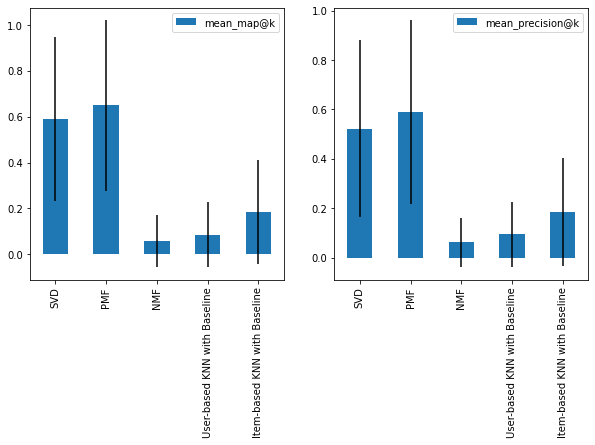

In [42]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

results_df.loc[['mean_map@k']].T.plot.bar(yerr=results_df.loc['std_map@k'],ax=axs[0])

results_df.loc[['mean_precision@k']].T.plot.bar(yerr=results_df.loc['std_precision@k'], ax=axs[1])

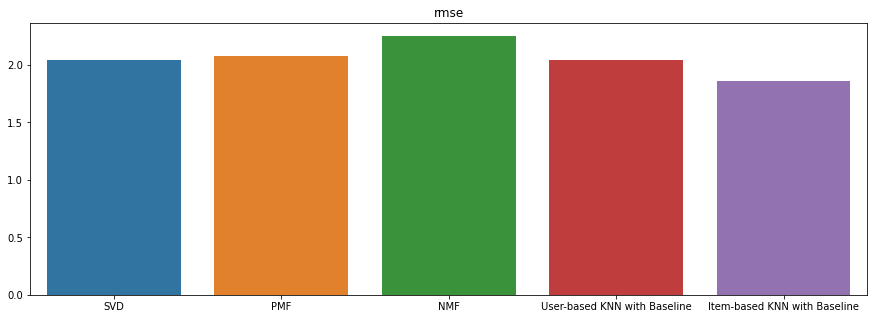

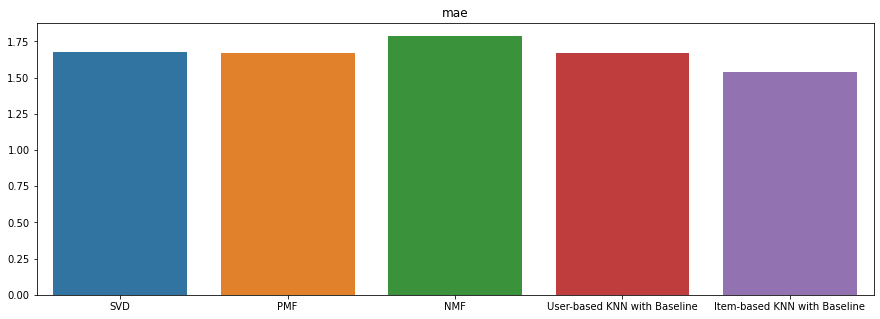

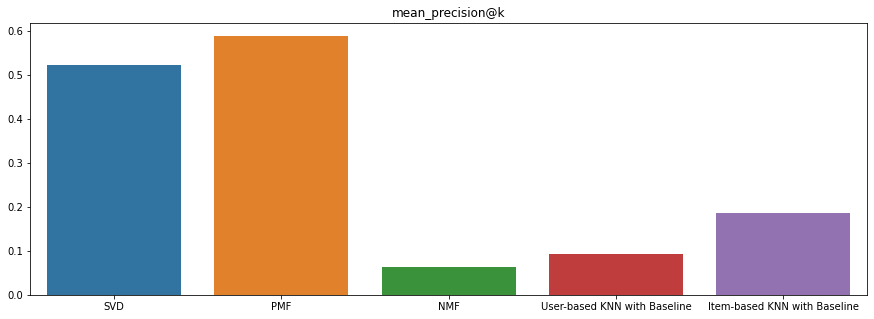

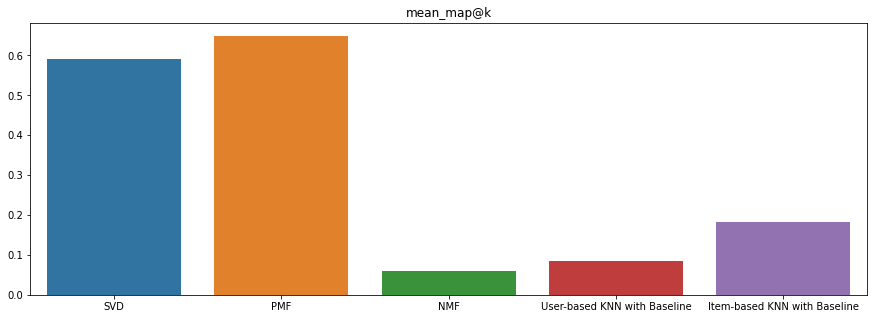

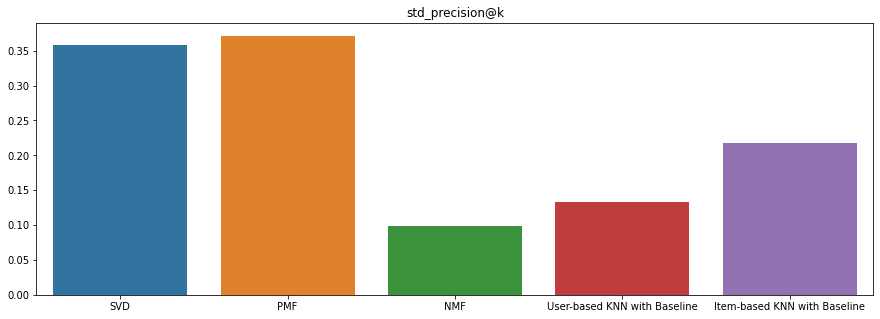

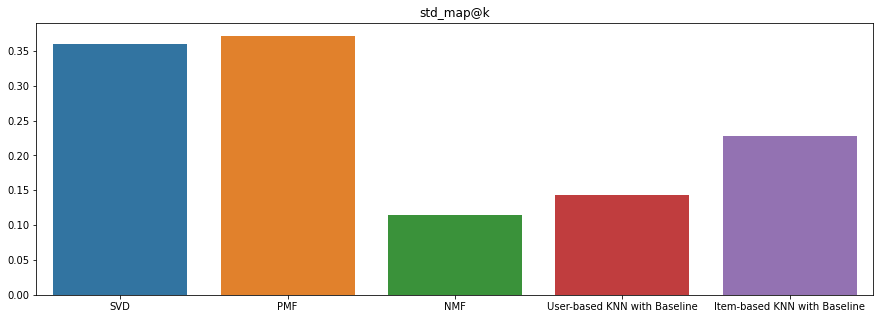

In [45]:
for col in results_df.index:
    plt.figure(figsize=(15,5))
    sns.barplot(data=results_df.loc[col].to_frame().T)
    plt.gca().set(title=col)
    plt.show()

## Testing on sampled users

In [71]:
# sample user
sampled_user = df_1kfamous['user-id'].sample(n=1).iloc[0]

# compute predictions
predicts = [final_algorithm.predict(uid=sampled_user, iid=x).est for x in df_1kfamous['track-id'].unique()]

# create df of tracks
predicts_df = pd.Series(df_1kfamous['track-id'].unique()).to_frame()

# add predictions to previous df
predicts_df['prediction'] = predicts

# get best songs predicted from svd
predicted_best = predicts_df.sort_values(by='prediction', ascending=False).head(5)[0]

# get the best songs by track
single_user = df_1kfamous[df_1kfamous['user-id'] == sampled_user]
target_best = single_user.sort_values(by='plays',ascending=False).head(5)['track-id']
print('Target')
print(famous_tracks[famous_tracks['musicbrainz-track-id'].isin(target_best)][['track-name','artist-name']].to_markdown())
print('Predicted')
print(famous_tracks[famous_tracks['musicbrainz-track-id'].isin(predicted_best)][['track-name','artist-name']].to_markdown())

Target
|      | track-name                      | artist-name         |
|-----:|:--------------------------------|:--------------------|
|  804 | Between The Bars                | Elliott Smith       |
| 2137 | Pierrot The Clown               | Placebo             |
| 3292 | Over The Pond                   | The Album Leaf      |
| 5210 | I Will Follow You Into The Dark | Death Cab For Cutie |
| 7815 | Angeles                         | Elliott Smith       |
Predicted
|      | track-name        | artist-name        |
|-----:|:------------------|:-------------------|
| 1939 | A Question Mark   | Elliott Smith      |
| 4157 | Paint It Black    | The Rolling Stones |
| 5841 | Pitseleh          | Elliott Smith      |
| 6388 | Tomorrow Tomorrow | Elliott Smith      |
| 6786 | Let It Die        | Feist              |


## Finding best tracks for a random user

In [ ]:
# get the best songs by track
single_user = df_1kfamous[df_1kfamous['user-id'] == 'user_000016']
target_best = single_user.sort_values(by='plays',ascending=False).head(5)['track-id']

In [ ]:
# compute predictions
predicts = [final_algorithm.predict(uid='user_000016', iid=x)[3] for x in df_1kfamous['track-id'].unique()]

# create df of tracks
predicts_df = pd.Series(df_1kfamous['track-id'].unique()).to_frame()

# add predictions to previous df
predicts_df['prediction'] = predicts

# get best songs predicted from svd
predicted_best = predicts_df.sort_values(by='prediction', ascending=False).head(5)[0]

**Actual most listened tracks**

In [ ]:
df_1kfamous[df_1kfamous['track-id'].isin(target_best)][['track-name','artist-name']].drop_duplicates()

**Best tracks retrieved by SVD**

In [ ]:
df_1kfamous[df_1kfamous['track-id'].isin(predicted_best)][['track-name','artist-name']].drop_duplicates()

## Full-Set SVD

In [ ]:
final_algorithm = SVDpp(n_factors=100, n_epochs=20, reg_all=0.05)
final_algorithm.fit(data.build_full_trainset())

## User clustering

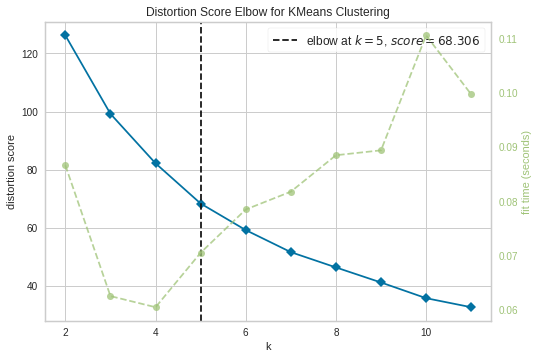

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [78]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

pca = PCA(n_components=2)
x2d = pca.fit_transform(final_algorithm.pu)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(x2d)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [81]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x2d = pca.fit_transform(final_algorithm.pu)

model = KMeans(n_clusters=5)
model.fit(x2d)

KMeans(n_clusters=5)

## Visualizing our clustering

In [117]:
userids = [full_set.to_raw_uid(uid) for uid in range(final_algorithm.pu.shape[0])]

userlabels = pd.DataFrame({'userid':userids,'label':model.labels_, 'x': x2d[:,0], 'y':x2d[:,1]} )

fig = px.scatter(userlabels,'x','y', color='label', custom_data=['userid'])
fig.update_traces(
    hovertemplate="<br>".join([
        "x: %{x}",
        "y: %{y}",
        "user-id: %{customdata[0]}"
    ])
)

Number of users per cluster :

In [98]:
np.bincount(model.labels_)

array([369,  68, 136,  68,  95])

### Aggregation techniques

In [239]:
def sample_k_users(df, k, num_clusters=5):
    
    # select one from each cluster
    num_per = np.bincount(list(map(lambda x : x%num_clusters, np.arange(k))))
    
    # sample user from number
    return sum([list(df[df['label'] == i]['userid'].sample(n=x).values) for i,x in enumerate(num_per)], [])
    
users = sample_k_users(userlabels, 5)

In [240]:
def predictions_from_users(df, users):
    # get list of all tracks
    tracks = df['track-id'].unique()
    
    # compute prediction for all users, all tracks
    predicts = [[final_algorithm.predict(uid=uid, iid=iid).est for uid in users] for iid in tracks]
    
    # create df from results
    predicts_df = pd.DataFrame(predicts)
    
    # add information about track, user
    predicts_df.index = tracks
    predicts_df.columns = users
    
    return predicts_df

In [241]:
def disagreement_variance(predicts_df):
    # init value
    values = np.zeros(predicts_df.shape[0])
    
    # iterate over all pairs of users
    for col1 in predicts_df.columns:
        for col2 in predicts_df.columns:
            if col1 != col2:
                # add difference
                values += np.abs(predicts_df[col1] - predicts_df[col2])
                
    return values * 2/(predicts_df.shape[1] * (predicts_df.shape[1] - 1))

In [242]:
def compute_group_ratings(predicts_df, relevance_coeff = 0.5, max_rating=10):
    # compute relevance
    average_relevance = predicts_df.mean(axis=1).to_frame('relevance') / max_rating
    # compute variance
    variance = disagreement_variance(predicts_df).to_frame('variance')
    # join back variance and relevance in a single rating
    group_ratings = average_relevance.join(variance)
    group_ratings['rating'] = (relevance_coeff*group_ratings['relevance']) + (1-relevance_coeff)*(1-group_ratings['variance'])
    return group_ratings

## Effect of number of users on the relevance (when sampling as many from each cluster)

In [268]:
uniform_sampler       = lambda df,k : list(df['userid'].sample(n=k))
first_cluster_sampler = lambda df,k : list(df[df['label'] == 0]['userid'].sample(n=k))

samplers      = [sample_k_users, uniform_sampler, first_cluster_sampler]
sampler_names = ['Uniform per cluster sampler', 'Uniform Sampler', 'Single cluster sampler']

In [269]:
mean_ratings = {}

all_ks = np.unique(np.geomspace(start=5, stop=100, num=10, dtype=int))
for sampler, sampler_name in zip(samplers, sampler_names):
    
    mean_ratings[sampler_name] = []
    
    for k in tqdm(all_ks):
        # sample k users from the clusters
        users = sampler(userlabels,k)

        # compute predictions for the given users
        predicts_df = predictions_from_users(df_reduced, users)

        # compute group ratings
        group_ratings = compute_group_ratings(predicts_df)

        # mean rating for top_k
        mean_ratings[sampler_name].append(group_ratings.sort_values(by='rating', ascending=False).head(10)['rating'].mean())

{'Uniform per cluster': [0.6199302252907,
  0.6290876203614344,
  0.5267134458521003,
  0.46100390387751655,
  0.4312002380392582,
  0.36746110998763737,
  0.3016337805563743,
  0.276459329011951,
  0.2504186511165552,
  0.20142572134913578],
 'Uniform Sampler': [0.5873179382454775,
  0.6520225462358666,
  0.4719153583939993,
  0.4048000610539663,
  0.5007013281628222,
  0.36354017653923265,
  0.3472728996236699,
  0.23739762076552445,
  0.22587348031326315,
  0.23765197526047013],
 'Single cluster sampler': [0.714009713619995,
  0.6755251526312895,
  0.566588657412804,
  0.49269045948174794,
  0.3899893310556803,
  0.3021384064873575,
  0.36368687540592204,
  0.2509194098644544,
  0.22938159797992091,
  0.22458889340917815]}

[Text(0.5, 1.0, 'Relevance (in [0,1]) as a function of group size'),
 Text(0.5, 0, 'Group Size'),
 Text(0, 0.5, 'Relevance')]

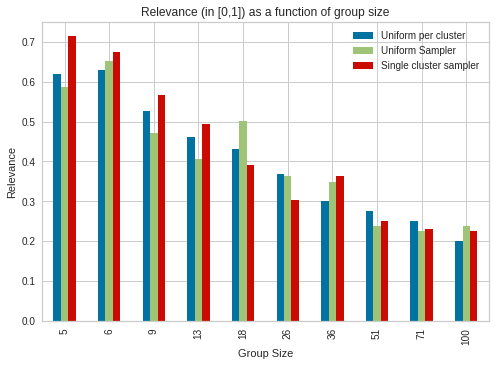

In [277]:
pd.DataFrame(mean_ratings).set_index(all_ks).plot(kind='bar')
plt.gca().set(title=f'Relevance (in [0,1]) as a function of group size', xlabel='Group Size', ylabel='Relevance')

## Effect of Relevance coefficient (0 => Minimize Disagreement, 1 => Maximize Average relevance)

In [361]:
k = 3
# sample k users from the clusters
users = first_cluster_sampler(userlabels,k)

In [363]:
for user in users:
    display(df_1kfamous[df_1kfamous['user-id'] == user].sort_values(by='plays',ascending=False).head(3)[['track-name', 'artist-name']])

track-name       artist-name
90961       The Birds  Telefon Tel Aviv
147593  Helen Of Troy  Telefon Tel Aviv
70704      Your Mouth  Telefon Tel Aviv

track-name        artist-name
69319   Kickstart The Fight        Combichrist
941          In The Flowers  Animal Collective
170925            Nightlife               Iamx

track-name             artist-name
17085           Closer         Nine Inch Nails
53449   The Bitter End                 Placebo
199583  Pale Blue Eyes  The Velvet Underground

In [371]:
for relevance_coeff in [0,0.5,1]:
    # compute predictions for the given users
    predicts_df = predictions_from_users(df_reduced, users)

    # compute group ratings
    group_ratings = compute_group_ratings(predicts_df, relevance_coeff=relevance_coeff)

    # mean rating for top_k
    top10_ratings = group_ratings.sort_values(by='rating', ascending=False).head(5)
    
    
    display(famous_tracks.merge(top10_ratings.reset_index(), right_on='index', left_on='musicbrainz-track-id')[['track-name', 'artist-name']])

track-name            artist-name
0                      The View           Modest Mouse
1              I Still Remember             Bloc Party
2                     Milkshake              Holy Fuck
3  Mellowship Slinky In B Major  Red Hot Chili Peppers
4                       Piranha            The Prodigy

track-name            artist-name
0              I Still Remember             Bloc Party
1                     Milkshake              Holy Fuck
2  Mellowship Slinky In B Major  Red Hot Chili Peppers
3                       Piranha            The Prodigy
4     Hate To Say I Told You So              The Hives

track-name       artist-name
0                                Closer   Nine Inch Nails
1                        The Bitter End           Placebo
2  You Are The Worst Thing In The World  Telefon Tel Aviv
3                   Kickstart The Fight       Combichrist
4                                   505    Arctic Monkeys

In [366]:
top10_ratings.reset_index()

index  relevance  variance    rating
0  3d76b996-e1fd-45e9-bfa4-82938799a9e8   0.688274  3.941257  0.688274
1  8dee0224-bcf9-4023-a805-9562bafd3450   0.677270  1.426679  0.677270
2  13dd61c7-ce73-4e97-9f0c-9f0e53144411   0.676932  4.136712  0.676932
3  4abc81d8-ed64-4a1f-a288-b0bca7762a49   0.675103  2.379775  0.675103
4  4f7356d7-a9af-4d21-a30e-6544658e9b52   0.672533  2.645425  0.672533

## Per user top-k from svd

In [ ]:
famous_tracks[famous_tracks['musicbrainz-track-id'].isin((list(ratings_df['user_000378'].sort_values(ascending=False).index)[:10]))]

In [ ]:
ratings_df['user_000657'].argmax()

In [ ]:
ratings_df.index[173]

In [ ]:
ratings_df.loc['c697b759-2ef6-43bb-a97a-2c56409abade']

In [ ]:
dic1 = famous_tracks.set_index('musicbrainz-track-id').to_dict(orient='index')
dic_trackname = {a:b['track-name'] for a,b in dic1.items()}
dic_artist_id = {a:b['musicbrainz-artist-id'] for a,b in dic1.items()}

In [ ]:
gb = ratings_df.T.melt(ignore_index=False).reset_index().groupby('index')
per_user_pref = gb.apply(lambda x : set(x.sort_values(by='value',ascending=False).head(10)['variable']))
user_pref = pd.DataFrame([list(x) for x in list(per_user_pref)]).T
user_pref.columns = user_sample
user_pref

In [ ]:
user_artists = df_1kfamous.groupby('user-id').apply(lambda x : set(x['artist-id']))

In [ ]:
per_user_listens = {a:b for a,b in zip(user_sample,list(map(lambda x: user_artists.loc[x], user_sample)))}

In [ ]:
user_art = user_pref.applymap(dic_artist_id.get)
for column in user_art:
    user_art[column] = user_art[column].isin(per_user_listens[column])

In [ ]:
user_pref.applymap(dic_trackname.get)

## Content Base Recommendations 

In [6]:
famous_tracks_rec = pd.read_csv('data/features.csv')

In [7]:
discrete_data = ['key', 'mode', 'time_signature', 'type']
continious_data = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', ]

In [8]:
for c in discrete_data :
    famous_tracks_rec[c] = famous_tracks_rec[c].astype('category').cat.codes

In [15]:
filtered_attrs = famous_tracks_rec.set_index(['musicbrainz-track-id'])[continious_data + discrete_data]

In [16]:
dist = DistanceMetric.get_metric('euclidean')
euclidean_genres_distance = dist.pairwise(filtered_attrs)

In [17]:
euclidean_genres_distance = euclidean_genres_distance / np.max(euclidean_genres_distance)

In [18]:
pd.DataFrame(euclidean_genres_distance)

0         1         2         3         4         5         6     \
0     0.000000  0.174918  0.005292  0.011311  0.013387  0.005168  0.067015   
1     0.174918  0.000000  0.180211  0.163607  0.188305  0.169750  0.107903   
2     0.005292  0.180211  0.000000  0.016603  0.008094  0.010460  0.072308   
3     0.011311  0.163607  0.016603  0.000000  0.024698  0.006143  0.055704   
4     0.013387  0.188305  0.008094  0.024698  0.000000  0.018555  0.080402   
...        ...       ...       ...       ...       ...       ...       ...   
7933  0.088895  0.086023  0.094188  0.077584  0.102282  0.083727  0.021880   
7934  0.007642  0.182560  0.002349  0.018953  0.005745  0.012810  0.074657   
7935  0.005417  0.180335  0.000129  0.016728  0.007970  0.010585  0.072432   
7936  0.007221  0.167697  0.012513  0.004090  0.020608  0.002053  0.059794   
7937  0.018703  0.156215  0.023996  0.007393  0.032090  0.013536  0.048312   

          7         8         9     ...      7928      7929      7930  \
0     0.013247  0.076905  0.046727  ...  0.035377  0.003387  0.015261   
1     0.161671  0.098013  0.128191  ...  0.139541  0.178305  0.159657   
2     0.018540  0.082198  0.052020  ...  0.040670  0.001905  0.020553   
3     0.001936  0.065594  0.035416  ...  0.024066  0.014698  0.003950   
4     0.026634  0.090292  0.060114  ...  0.048764  0.010000  0.028648   
...        ...       ...       ...  ...       ...       ...       ...   
7933  0.075648  0.011990  0.042168  ...  0.053518  0.092283  0.073634   
7934  0.020889  0.084547  0.054369  ...  0.043019  0.004255  0.022903   
7935  0.018664  0.082322  0.052145  ...  0.040794  0.002030  0.020678   
7936  0.006026  0.069684  0.039506  ...  0.028156  0.010608  0.008040   
7937  0.005456  0.058202  0.028024  ...  0.016674  0.022091  0.003442   

          7931      7932      7933      7934      7935      7936      7937  
0     0.023192  0.029764  0.088895  0.007642  0.005417  0.007221  0.018703  
1     0.198110  0.204682  0.086023  0.182560  0.180335  0.167697  0.156215  
2     0.017899  0.024472  0.094188  0.002349  0.000129  0.012513  0.023996  
3     0.034502  0.041075  0.077584  0.018953  0.016728  0.004090  0.007393  
4     0.009805  0.016377  0.102282  0.005745  0.007970  0.020608  0.032090  
...        ...       ...       ...       ...       ...       ...       ...  
7933  0.112087  0.118660  0.000000  0.096537  0.094312  0.081674  0.070192  
7934  0.015550  0.022123  0.096537  0.000000  0.002225  0.014863  0.026345  
7935  0.017774  0.024347  0.094312  0.002225  0.000000  0.012638  0.024121  
7936  0.030413  0.036985  0.081674  0.014863  0.012638  0.000000  0.011482  
7937  0.041895  0.048468  0.070192  0.026345  0.024121  0.011482  0.000000  

[7938 rows x 7938 columns]

In [19]:
genres_tracks = famous_tracks_rec['genres']
genres_tracks

0       {'alternative rock', 'dance-punk', 'indie rock...
1       {'bow pop', 'dream pop', 'compositional ambien...
2       {'gothenburg indie', 'swedish indie folk', 'ne...
3       {'new romantic', 'permanent wave', 'new wave',...
4       {'filter house', 'nu disco', 'dance-punk', 'el...
                              ...                        
7933    {'philly indie', 'alternative rock', 'dance-pu...
7934                         {'british soul', 'neo soul'}
7935    {'dance-punk', 'indie rock', 'new rave', 'nort...
7936    {'dance-punk', 'new rave', 'electronica', 'ind...
7937    {'permanent wave', 'alternative rock', 'rock',...
Name: genres, Length: 7938, dtype: object

The handling of the set of genres was inspired by the following work : https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

In [20]:
genres_tracks = genres_tracks.apply(lambda x : list(eval(x)))

In [21]:
unique_genres = set()

for g in genres_tracks:
    for i in g :
        unique_genres.add(i)
        
unique_genres

{'a cappella',
 'abstract',
 'abstract hip hop',
 'acid house',
 'acid rock',
 'acoustic pop',
 'acoustic punk',
 'acoustic rock',
 'action rock',
 'adult standards',
 'afrobeat',
 'afrofuturism',
 'afropop',
 'aggrotech',
 'alabama indie',
 'album rock',
 'albuquerque indie',
 'alternative country',
 'alternative dance',
 'alternative hip hop',
 'alternative metal',
 'alternative pop',
 'alternative r&b',
 'alternative rock',
 'ambient',
 'ambient folk',
 'ambient pop',
 'ambient techno',
 'american contemporary classical',
 'american metalcore',
 'american post-rock',
 'anarcho-punk',
 'anti-folk',
 'appalachian folk',
 'argentine ambient',
 'argentine rock',
 'arkansas country',
 'art pop',
 'art punk',
 'art rock',
 'athens indie',
 'atl hip hop',
 'atlanta indie',
 'atlanta metal',
 'atmospheric black metal',
 'atmospheric doom',
 'aussietronica',
 'austindie',
 'australian alternative rock',
 'australian dance',
 'australian electropop',
 'australian garage punk',
 'australian in

In [22]:
def generate_col_for_genre(tracks, unique_genres) :
    bool_dict = {}
    for i, item in enumerate(unique_genres):
        bool_dict[item] = tracks.apply(lambda x: item in x)
    return pd.DataFrame(bool_dict)
    

In [23]:
genres_bool = generate_col_for_genre(genres_tracks, unique_genres)

In [24]:
genres_bool.astype(int)

new rave  swedish progressive metal  country gospel  south african rock  \
0            0                          0               0                   0   
1            0                          0               0                   0   
2            0                          0               0                   0   
3            0                          0               0                   0   
4            1                          0               0                   0   
...        ...                        ...             ...                 ...   
7933         1                          0               0                   0   
7934         0                          0               0                   0   
7935         1                          0               0                   0   
7936         1                          0               0                   0   
7937         0                          0               0                   0   

      experimental vocal  beatlesque  glam metal  isle of wight indie  \
0                      0           0           0                    0   
1                      0           0           0                    0   
2                      0           0           0                    0   
3                      0           0           0                    0   
4                      0           0           0                    0   
...                  ...         ...         ...                  ...   
7933                   0           0           0                    0   
7934                   0           0           0                    0   
7935                   0           0           0                    0   
7936                   0           0           0                    0   
7937                   0           0           0                    0   

      riot grrrl  modern bollywood  ...  swedish synthpop  german jazz rap  \
0              0                 0  ...                 0                0   
1              0                 0  ...                 0                0   
2              0                 0  ...                 0                0   
3              0                 0  ...                 0                0   
4              0                 0  ...                 0                0   
...          ...               ...  ...               ...              ...   
7933           0                 0  ...                 0                0   
7934           0                 0  ...                 0                0   
7935           0                 0  ...                 0                0   
7936           0                 0  ...                 0                0   
7937           0                 0  ...                 0                0   

      braindance  hip house  samba  argentine rock  stoner rock  \
0              0          0      0               0            0   
1              0          0      0               0            0   
2              0          0      0               0            0   
3              0          0      0               0            0   
4              0          0      0               0            0   
...          ...        ...    ...             ...          ...   
7933           0          0      0               0            0   
7934           0          0      0               0            0   
7935           0          0      0               0            0   
7936           0          0      0               0            0   
7937           0          0      0               0            0   

      louisville indie  belgian rock  miami hip hop  
0                    0             0              0  
1                    0             0              0  
2                    0             0              0  
3                    0             0              0  
4                    0             0              0  
...                ...           ...            ...  
7933                 0             0

In [25]:
dist = DistanceMetric.get_metric('hamming')
hamming_genres_distance = dist.pairwise(genres_bool)

In [26]:
hamming_genres_distance /= np.max(hamming_genres_distance)

In [27]:
pd.DataFrame(hamming_genres_distance)

0         1         2         3         4         5         6     \
0     0.000000  0.351351  0.324324  0.270270  0.270270  0.243243  0.351351   
1     0.351351  0.000000  0.405405  0.351351  0.405405  0.378378  0.432432   
2     0.324324  0.405405  0.000000  0.324324  0.378378  0.351351  0.351351   
3     0.270270  0.351351  0.324324  0.000000  0.270270  0.297297  0.405405   
4     0.270270  0.405405  0.378378  0.270270  0.000000  0.351351  0.459459   
...        ...       ...       ...       ...       ...       ...       ...   
7933  0.270270  0.567568  0.486486  0.486486  0.378378  0.513514  0.351351   
7934  0.189189  0.270270  0.243243  0.189189  0.243243  0.216216  0.324324   
7935  0.135135  0.378378  0.351351  0.297297  0.243243  0.324324  0.378378   
7936  0.243243  0.378378  0.351351  0.243243  0.135135  0.324324  0.432432   
7937  0.135135  0.324324  0.297297  0.189189  0.297297  0.216216  0.378378   

          7         8         9     ...      7928      7929      7930  \
0     0.243243  0.216216  0.162162  ...  0.459459  0.270270  0.108108   
1     0.324324  0.297297  0.297297  ...  0.540541  0.351351  0.297297   
2     0.243243  0.270270  0.270270  ...  0.513514  0.270270  0.270270   
3     0.243243  0.216216  0.216216  ...  0.405405  0.270270  0.162162   
4     0.297297  0.270270  0.270270  ...  0.405405  0.324324  0.270270   
...        ...       ...       ...  ...       ...       ...       ...   
7933  0.459459  0.432432  0.324324  ...  0.567568  0.486486  0.378378   
7934  0.162162  0.135135  0.135135  ...  0.378378  0.189189  0.135135   
7935  0.270270  0.243243  0.189189  ...  0.486486  0.297297  0.189189   
7936  0.270270  0.243243  0.243243  ...  0.378378  0.297297  0.243243   
7937  0.216216  0.189189  0.189189  ...  0.378378  0.243243  0.081081   

          7931      7932      7933      7934      7935      7936      7937  
0     0.162162  0.243243  0.270270  0.189189  0.135135  0.243243  0.135135  
1     0.243243  0.378378  0.567568  0.270270  0.378378  0.378378  0.324324  
2     0.216216  0.351351  0.486486  0.243243  0.351351  0.351351  0.297297  
3     0.162162  0.297297  0.486486  0.189189  0.297297  0.243243  0.189189  
4     0.216216  0.351351  0.378378  0.243243  0.243243  0.135135  0.297297  
...        ...       ...       ...       ...       ...       ...       ...  
7933  0.378378  0.513514  0.000000  0.405405  0.297297  0.351351  0.405405  
7934  0.081081  0.216216  0.405405  0.000000  0.216216  0.216216  0.162162  
7935  0.189189  0.324324  0.297297  0.216216  0.000000  0.216216  0.270270  
7936  0.189189  0.324324  0.351351  0.216216  0.216216  0.000000  0.270270  
7937  0.135135  0.216216  0.405405  0.162162  0.270270  0.270270  0.000000  

[7938 rows x 7938 columns]

In [28]:
global_distance = hamming_genres_distance*0.5 + euclidean_genres_distance*0.5

In [29]:
global_distance = pd.DataFrame(global_distance)

In [30]:
def find_n_closest_songs(song, n) :    
    return list(global_distance.nsmallest(n + 1, 0).index)

In [40]:
target_track = famous_tracks_rec.iloc[0]
songs = find_n_closest_songs(target_track, 10)
famous_tracks_rec.loc[songs][['artist-name', 'track-name', 'genres']]

artist-name                                  track-name  \
0     The Dandy Warhols    Not If You Were The Last Junkie On Earth   
1719  The Dandy Warhols                                     Get Off   
5766  The Dandy Warhols                       We Used To Be Friends   
432   The Dandy Warhols                                  Minnesoter   
5859  The Dandy Warhols                           Bohemian Like You   
5926      Kaiser Chiefs                    Always Happens Like That   
4910      Kaiser Chiefs  Love'S Not A Competition (But I'M Winning)   
510       Kaiser Chiefs                           Never Miss A Beat   
2826      Kaiser Chiefs                                        Ruby   
6824      Kaiser Chiefs                             Na Na Na Na Naa   
7242      Kaiser Chiefs                            Like It Too Much   

                                                 genres  
0     {'alternative rock', 'dance-punk', 'indie rock...  
1719  {'alternative rock', 'dance-punk', 'indie rock...  
5766  {'alternative rock', 'dance-punk', 'indie rock...  
432   {'alternative rock', 'dance-punk', 'indie rock...  
5859  {'alternative rock', 'dance-punk', 'indie rock...  
5926  {'modern rock', 'alternative rock', 'dance-pun...  
4910  {'modern rock', 'alternative rock', 'dance-pun...  
510   {'modern rock', 'alternative rock', 'dance-pun...  
2826  {'modern rock', 'alternative rock', 'dance-pun...  
6824  {'modern rock', 'alternative rock', 'dance-pun...  
7242  {'modern rock', 'alternative rock', 'dance-pun...

--- 

# Non-conclusive attempts

# Tensorflow recommender

In [3]:
from sklearn.metrics import roc_auc_score
import scipy.sparse as sp
import tensorflow as tf
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import datetime
import time 
import math
import os

### Important information

In [4]:
no_users, no_items, no_ratings = (len(df_1kfamous['user-id'].unique()),
                                  len(df_1kfamous['track-id'].unique()),
                                  len(df_1kfamous.index))

### Rescaling ids

In [5]:
df_1kfamous['original_user_id'] = df_1kfamous['user-id']
df_1kfamous['original_item_id'] = df_1kfamous['track-id']
df_1kfamous['user_id'] = df_1kfamous['user-id'].astype('category').cat.codes
df_1kfamous['item_id'] = df_1kfamous['track-id'].astype('category').cat.codes

### Train test split

In [6]:
from sklearn.model_selection import train_test_split
train_ratings, test_ratings = train_test_split(df_1kfamous,test_size=0.2, random_state=42)

In [7]:
no_users, no_items, no_ratings

(805, 7938, 217449)

In [8]:
train_ratings.shape, train_ratings['user_id'].nunique()

((173959, 11), 797)

In [9]:
test_ratings.shape, test_ratings['user_id'].nunique()

((43490, 11), 772)

### Latent factor model

In [10]:
def create_shallow_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Dot product 
    vectors_product = tf.keras.layers.dot([user_vector, item_vector], axes=1, normalize=False)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[vectors_product], name='shallow_model')
    return model

In [11]:
def create_deep_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Concantenation
    vectors_concat = tf.keras.layers.Concatenate()([user_vector, item_vector])
    vectors_concat_dropout = tf.keras.layers.Dropout(0.2)(vectors_concat)
    # Backbone 
    dense_1 = tf.keras.layers.Dense(16,name='fc3')(vectors_concat_dropout)
    dropout_1 = tf.keras.layers.Dropout(0.2,name='d3')(dense_1)
    dense_2 = tf.keras.layers.Dense(8,name='fc4', activation='relu')(dropout_1)
    dense_2_output = tf.keras.layers.Dense(1, activation='relu', name='activation')(dense_2)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[dense_2_output], name='deep_model')
    return model

In [12]:
no_factors=100
model = create_deep_model(no_factors, no_users, no_items)
model.compile(loss=tf.keras.losses.MeanSquaredError())

model.summary()

Model: "deep_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_matrix (Embedding)         (None, 1, 100)       80600       user_id[0][0]                    
__________________________________________________________________________________________________
item_matrix (Embedding)         (None, 1, 100)       793900      item_id[0][0]                    
_________________________________________________________________________________________

In [13]:
X_train = [train_ratings.user_id, train_ratings.item_id]
y_train = train_ratings.qcat_plays
model.fit(X_train, y_train, validation_split=0.2,epochs=20, batch_size=256, shuffle=True)

AttributeError: 'DataFrame' object has no attribute 'qcat_plays'

In [ ]:
X_test = [test_ratings.user_id, test_ratings.item_id]
y_test = test_ratings.qcat_plays
y_test_pred = model.predict(X_test, batch_size=2048)

In [ ]:
a,b = np.meshgrid(range(no_items),range(no_users))
all_preds = model.predict([np.ravel(b), np.ravel(a)], batch_size=2048)
all_preds = all_preds.reshape((no_users, no_items))

In [ ]:
selected_user = 600

predicted_best = all_preds[selected_user].argsort()[::-1][:5]
print(df_1kfamous[df_1kfamous['item_id'].isin(predicted_best)][['artist-name','track-name']].drop_duplicates())
df_1kfamous[df_1kfamous['user_id'] == selected_user].sort_values(ascending=False, by='plays')[['artist-name','track-name']].drop_duplicates().head(5)

In [ ]:
from sklearn.metrics import mean_squared_error
print('Test RMSE:', mean_squared_error(y_test.values, y_test_pred, squared=False))

### Evaluation